In [1]:
!pip install pandas
!pip install torch

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

In [6]:
df=pd.read_csv('TSLA[1].csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [7]:
closed_prices = df["Close"]

In [11]:
seq_len=15

In [12]:
mm=MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [13]:
X=[]
Y=[]

In [14]:
for i in range(len(scaled_price)-seq_len):
  X.append(scaled_price[i:i+seq_len])
  Y.append(scaled_price[i+seq_len])

In [15]:
X=np.array(X)[... , None]
Y=np.array(Y)[... , None]

In [16]:
train_x= torch.from_numpy(X[:int(0.8*X.shape[0])]).float()
train_y= torch.from_numpy(Y[:int(0.8*X.shape[0])]).float()
test_x= torch.from_numpy(X[int(0.8*X.shape[0]):]).float()
test_y= torch.from_numpy(Y[int(0.8*X.shape[0]):]).float()

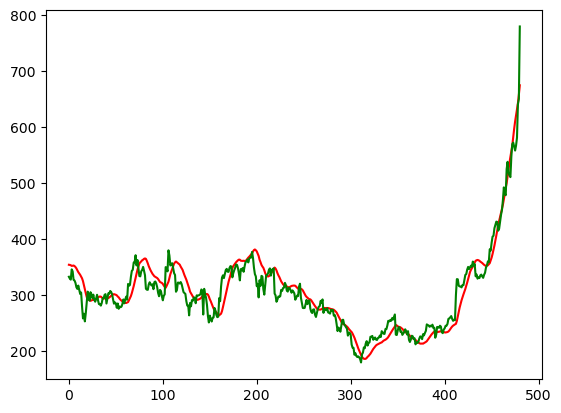

In [17]:
class Model(nn.Module):
  def __init__(self,input_size,hidden_size):
    super(Model,self).__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,batch_first = True)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    output,(hidden,cell)=self.lstm(x)
    return self.fc(output[:,-1,:])
model = Model(1,96)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn=nn.MSELoss()

num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
if epoch % 10 == 0 and epoch != 0:
  print(epoch, "epoch loss", loss.detach().numpy())
model.eval()
with torch.no_grad():
  output = model(test_x)
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
plt.plot(pred.squeeze(), color = 'red',label = 'predicted')
plt.plot(real.squeeze(), color= 'green',label='predicted')
plt.show()